<a href="https://colab.research.google.com/github/blurred421/LFD473-code/blob/main/notebooks/Chapter12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12: Datasets and Transformations for Object Detection and Image Segmentation

In [ ]:
!pip install albumentations

## 12.2 Learning Objectives

By the end of this chapter, you should be able to:
- annotate datasets for object detection
- convert bounding boxes from one coordinate system to another
- transform segmentation masks into bounding boxes
- apply appropriate transformations using Torchvision's DataPoints
- build a custom dataset for object detection

## 12.3 Object Detection, Image Segmentation, and Keypoint Detection

### 12.3.1 Object Detection

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch10/tv_image01.png)

### 12.3.2 Segmentation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch10/tv_image02.png)

### 12.3.3 Keypoint Detection

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch10/sphx_glr_plot_visualization_utils_012.png)

## 12.4 Bounding Boxes

### 12.4.1 Box Coordinates Systems

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch10/bbox_example.jpg)

Let's see how this red box would be represented in different coordinate systems.

- Pascal VOC: This type of coordinates was defined for the [Pascal VOC - Visual Object Classes]((http://host.robots.ox.ac.uk/pascal/VOC/)) datasets and challenges.
  - it uses the absolute values (in number of pixels) for the coordinates of both upper-left and bottom-right corners of the bounding box: `[x_min, y_min, x_max, y_max]`
  - in Torchvision, it is represented as `torchvision.tv_tensors.BoundingBoxFormat.XYXY`
  - in the image above, the coordinates of red bounding box in Pascal VOC format are: `[98, 345, 420, 462]`

- COCO: This type of coordinates was defined for the [COCO - Common Objects in Context](https://cocodataset.org/#home) datasets and competitions we already discussed.
  - it uses the absolute values (in number of pixels) for the coordinates of the upper-left corner, followed by the width and height (in number of pixels) of the bounding box: `[x_min, y_min, box_width, box_height]`
  - in Torchvision, it is represented as `torchvision.tv_tensors.BoundingBoxFormat.XYWH`
  - in the image above, the coordinates of red bounding box in COCO format are: `[98, 345, 322, 117]`

- YOLO: This type of coordinates was defined for the [YOLO - You Only Look Once]((https://pjreddie.com/darknet/yolo/)) series of models.
   - it uses standardized values for the coordinates of the center (midpoint), width, and height of the bounding box, dividing the box's X and width by the image's total width, and dividing the box's Y and height by the image's total height: `[x_center/image_width, y_center/image_height, box_width/image_width, box_height/image_height]`
   - its raw (not standardized) version is represented in Torchvision as `torchvision.tv_tensors.BoundingBoxFormat.CXCYWH`
   - in the image above, the coordinates of red bounding box in YOLO format are: `[0.4046875, 0.840625, 0.503125, 0.24375]`


## 12.5 Torchvision Operators

The [ops](https://pytorch.org/vision/main/ops.html) submodule of Torchvision implements operators, losses, and layers that are specific for computer vision tasks, and all operators have native support to TorchScript.

The operators are divided into four groups:
- [detection and segmentation operators](https://pytorch.org/vision/main/ops.html#detection-and-segmentation-operators): includes pre- and post-processing operations typically required in object detection and segmentation models, such as `masks_to_boxes()`, `FeaturePyramidNetwork()`, and `MultiScaleRoIAlign()`, which we'll be covered in the next chapter
- [box operators](https://pytorch.org/vision/main/ops.html#box-operators): utility functions to perform operations on bounding boxes, our next topic, such as `box_area()` and `box_convert()`
- [losses](https://pytorch.org/vision/main/ops.html#losses): vision-specific loss functions, mostly based on the Intersection over Union (IoU) metric (which we'll cover in the "Evaluation" section), such as `complete_box_iou_loss()`
- [layers](https://pytorch.org/vision/main/ops.html#layers): commonly used building blocks for computer vision models, such as `Conv2dNormActivation()` and `MLP()`.

### 12.5.1 Box Operators

#### 12.5.1.1 Converting Coordinates

In [ ]:
import torch
from torchvision.ops import box_convert

pascal_coord = torch.tensor([[98, 345, 420, 462]]).float()  # xyxy

# Converting from Pascal to COCO - xyxy to xywh
coco_coord = box_convert(pascal_coord, 'xyxy', 'xywh')

# Converting from COCO to (raw) YOLO - xywh to cxcywh
raw_yolo_coord = box_convert(coco_coord, 'xywh', 'cxcywh')
yolo_coord = raw_yolo_coord / torch.tensor([[640, 480, 640, 480]])

# Converting from (raw) YOLO back to Pascal - cxcywh to xyxy
pascal_coord = box_convert(raw_yolo_coord, 'cxcywh', 'xyxy')

# Converting to Albumentations - standardizing Pascal
albumentations_coord = pascal_coord / torch.tensor([[640, 480, 640, 480]])

print(f'COCO: {coco_coord}\nYOLO: {yolo_coord}\nPascal VOC: {pascal_coord}\nAlbumentations: {albumentations_coord}')

COCO: tensor([[ 98., 345., 322., 117.]])
YOLO: tensor([[0.4047, 0.8406, 0.5031, 0.2438]])
Pascal VOC: tensor([[ 98., 345., 420., 462.]])
Albumentations: tensor([[0.1531, 0.7188, 0.6562, 0.9625]])


#### 12.5.1.2 Box Area

In [ ]:
from torchvision.ops import box_area

box_area(pascal_coord)

tensor([37674.])

#### 12.5.1.3 XML2CSV

Here is an example of an annotation in XML format from the [Oxford IIIT Pets](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html) dataset:

```xml
<annotation>
    <folder>OXIIIT</folder>
    <filename>Abyssinian_100.jpg</filename>
    <source>
        <database>OXFORD-IIIT Pet Dataset</database>
        <annotation>OXIIIT</annotation>
        <image>flickr</image>
    </source>
    <size>
        <width>394</width>
        <height>500</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Frontal</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <bndbox>
            <xmin>151</xmin>
            <ymin>71</ymin>
            <xmax>335</xmax>
            <ymax>267</ymax>
        </bndbox>
        <difficult>0</difficult>
    </object>
</annotation>
```

The `xml_to_csv()` helper function below, from TensorFlow's [Training Custom Object Detector](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records), can be used to convert a batch of XML files containing annotations into a single Pandas dataframe:

In [ ]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

### 12.5.2 Annotations

#### 12.5.2.1 LabelImg / Label Studio

[Label Studio](https://github.com/heartexlabs/label-studio) is a multi-type data labeling and annotation tool with standardized output format. It is the successor of the popular LabelImg graphical image annotation tool, and it includes many different types of annotations for different tasks. You can try them out in the [playground](https://labelstud.io/playground/).

#### 12.5.2.2 VGG Image Annotator

[VIA](https://www.robots.ox.ac.uk/~vgg/software/via/), the VGG Image Annotator, is a simple and standalone manual annotation software for image, audio, and video, and it runs on the web browser. You can use its [online version](https://www.robots.ox.ac.uk/~vgg/software/via/via.html) to annotate your own images.

#### 12.5.2.3 FiftyOne

[FiftyOne](https://docs.voxel51.com/index.html) is an open source tool for building datasets and computer vision models. It enables you to visualize and annotate complex data, evaluate your model's predictions, and more. You can try it out on Google Colab using its [Quickstart](https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/quickstart.ipynb) notebook.

#### 12.5.2.4 Colab Utils

In Google Colab, you can also run a simple interface for drawing bounding boxes directly in your notebook. It is one of the [utilities](https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/colab_utils.py) in TensorFlow's object detection repo.

The original `annotate()` helper function uses a fixed height of 600 pixels in its interface, and this may distort the boxes if you're annotating small images. Also, it returned the coordinates as standardized `[ymin/height, xmin/width, ymax/height, xmax/width]` which isn't compatible with any of the presented standards. Therefore, we modified the function to both remove the height restriction, and to return coordinates in the standardized Pascal VOC (Albumenatations) coordinates `[xmin/width, ymin/height, xmax/width, ymax/height]` instead.

The function takes two arguments:
- a list of Numpy arrays containing pixel values
- a list variable that will receive the resulting annotations

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/colab_utils.py

In [ ]:
!wget https://github.com/dvgodoy/assets/raw/main/PyTorchInPractice/data/Fruits360/images.zip
!unzip images.zip -d images

In [ ]:
import numpy as np
import PIL

numpy_images = [np.array(PIL.Image.open(f'./images/pineapple/{i}.jpg')) for i in range(5)]
numpy_images

[array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[20, 20, 20],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 9,  9,  9]],
 
        [[41, 41, 41],
         [ 3,  3,  3],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [15, 15, 15],
         [51, 51, 51]],
 
        [[59, 59, 59],
         [ 8,  8,  8],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 1,  1,  1],
         [51, 51, 51]]], dtype=uint8),
 array([[[235, 240, 246],
         [232, 2

In [ ]:
from colab_utils import annotate
annotated_boxes = []
annotate(numpy_images, box_storage_pointer=annotated_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch10/colab_utils.png)

In [ ]:
annotated_boxes

[array([[0.20886076, 0.0037037 , 0.77637131, 0.96150961]]),
 array([[0.56751055, 0.11172042, 0.73417722, 0.78591397]]),
 array([[0.27637131, 0.08634336, 0.74683544, 0.90239688]]),
 array([[0.14135021, 0.26671355, 0.87763713, 0.91931552]]),
 array([[0.31012658, 0.04967136, 0.59493671, 0.7426291 ],
        [0.58438819, 0.17079812, 0.84388186, 0.86375586]])]

In [ ]:
annotated_boxes = [
  np.array([[0.20886076, 0.0037037 , 0.77637131, 0.96150961]]),
  np.array([[0.56751055, 0.11172042, 0.73417722, 0.78591397]]),
  np.array([[0.27637131, 0.08634336, 0.74683544, 0.90239688]]),
  np.array([[0.14135021, 0.26671355, 0.87763713, 0.91931552]]),
  np.array([[0.31012658, 0.04967136, 0.59493671, 0.7426291 ],
            [0.58438819, 0.17079812, 0.84388186, 0.86375586]])
]

In [ ]:
images_hw = [np.array([*img.shape[:2][::-1], *img.shape[:2][::-1]]) for img in numpy_images]
images_hw

[array([474, 711, 474, 711]),
 array([474, 310, 474, 310]),
 array([474, 598, 474, 598]),
 array([474, 711, 474, 711]),
 array([474, 355, 474, 355])]

In [ ]:
annotated_boxes[1] * images_hw[1]

array([[269.0000007 ,  34.6333302 , 348.00000228, 243.6333307 ]])

### 12.5.3 Drawing Boxes

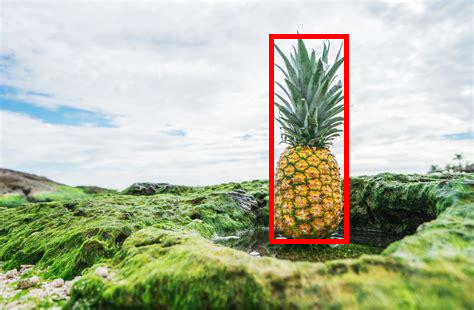

In [ ]:
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToPILImage

i = 1
img = read_image(f'./images/pineapple/{i}.jpg')
boxes = torch.as_tensor(annotated_boxes[i] * images_hw[i])
result = draw_bounding_boxes(img, boxes, colors=['red']*boxes.shape[0], width=5)
ToPILImage()(result)

### 12.5.4 Masks

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step1.png)

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

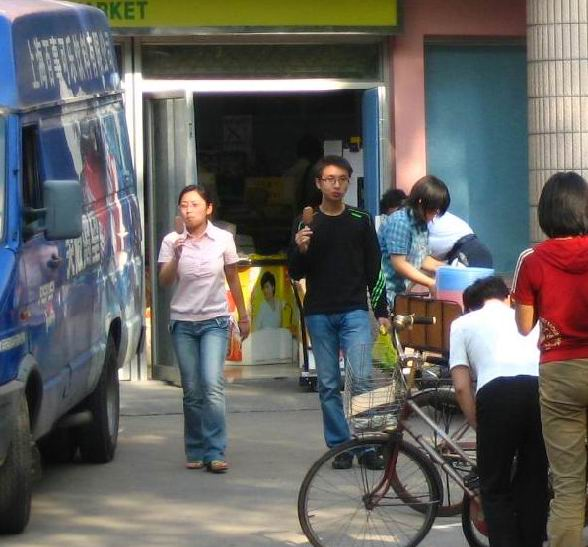

In [ ]:
PIL.Image.open('PennFudanPed/PNGImages/FudanPed00042.png')

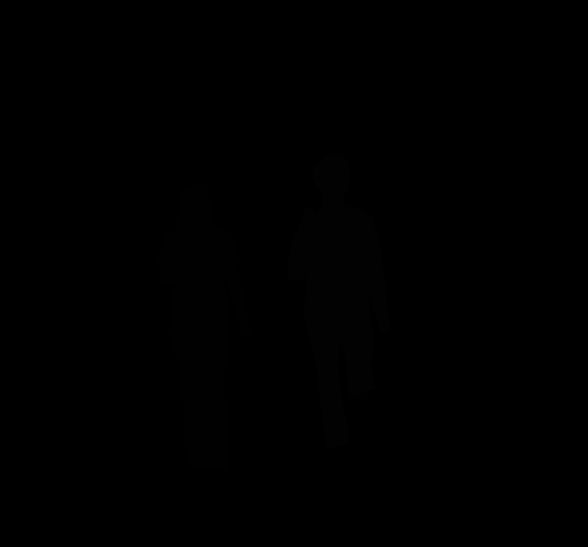

In [ ]:
mask_filename = 'PennFudanPed/PedMasks/FudanPed00042_mask.png'
mask_image = PIL.Image.open(mask_filename)
mask_image

In [ ]:
mask_array = np.array(mask_image)
mask_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
np.unique(mask_array)

array([0, 1, 2], dtype=uint8)

In [ ]:
colors = [
    0, 0, 0,     # 0 = black
    255, 0, 0,   # 1 = red
    255, 255, 0, # 2 = yellow
]
colors

[0, 0, 0, 255, 0, 0, 255, 255, 0]

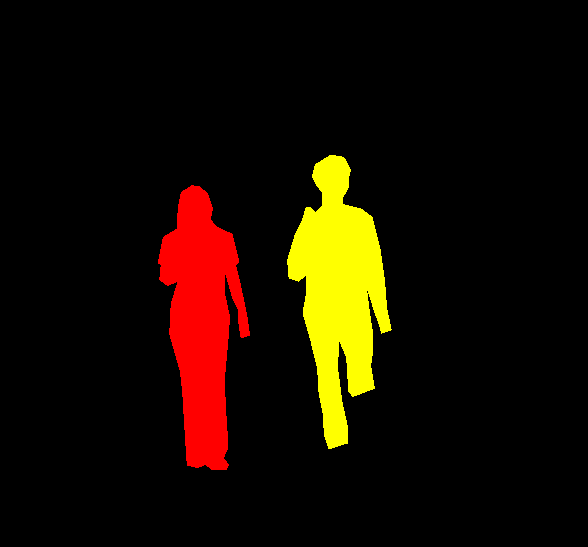

In [ ]:
mask_image.putpalette(colors, rawmode='RGB')
mask_image

In [ ]:
merged_mask = read_image(mask_filename)
masks = (merged_mask == merged_mask.unique()[1:].view(-1, 1, 1))
masks.shape

torch.Size([2, 547, 588])

In [ ]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(masks)
boxes

tensor([[158., 185., 249., 469.],
        [287., 155., 391., 448.]])

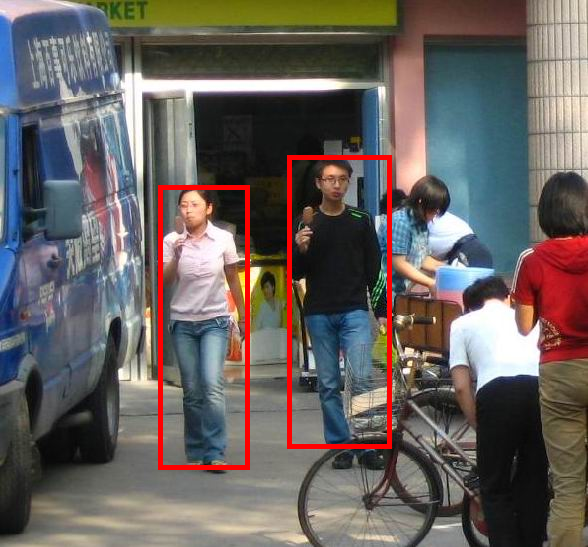

In [ ]:
image = read_image('PennFudanPed/PNGImages/FudanPed00042.png')
result = draw_bounding_boxes(image, boxes, colors=['red']*boxes.shape[0], width=5)
ToPILImage()(result)

### 12.5.5 Data Augmentation Revisited

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

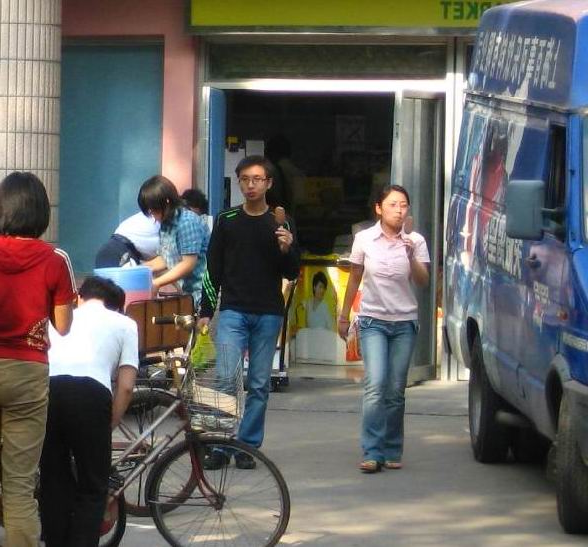

In [ ]:
from torchvision.transforms import RandomHorizontalFlip

# forcing the flipping to happen by setting probability to 1.0
flip = RandomHorizontalFlip(p=1.0)
flipped_tensor = flip(image)
ToPILImage()(flipped_tensor)

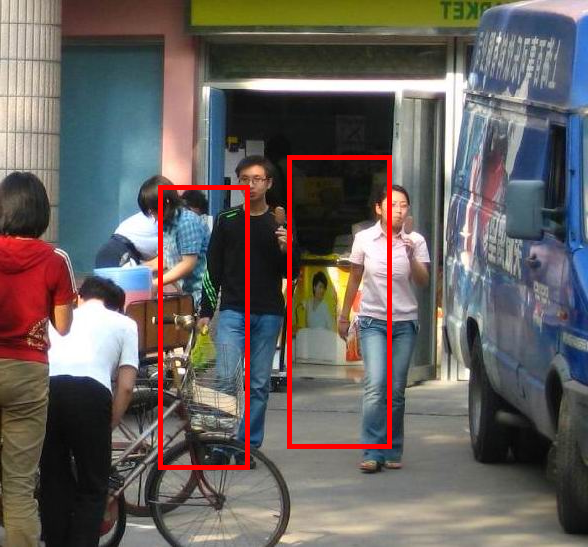

In [ ]:
result = draw_bounding_boxes(flipped_tensor, boxes, colors=['red']*boxes.shape[0], width=5)
ToPILImage()(result)

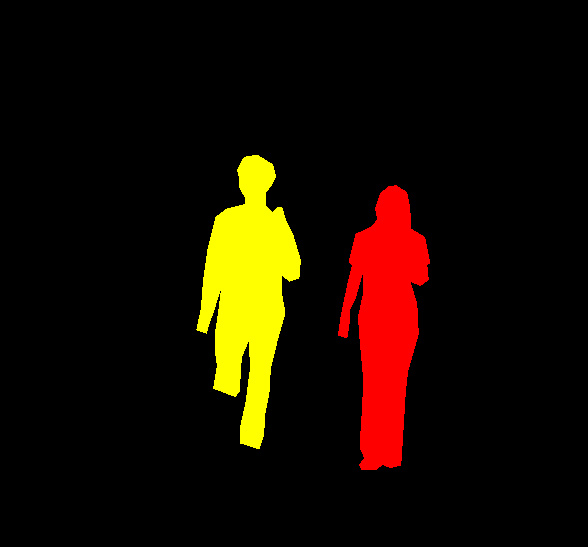

In [ ]:
flipped_mask = flip(merged_mask)
flipped_mask_image = ToPILImage()(flipped_mask)
flipped_mask_image.putpalette(colors, rawmode='RGB')
flipped_mask_image

In [ ]:
flipped_masks = (flipped_mask == flipped_mask.unique()[1:].view(-1, 1, 1))
flipped_boxes = masks_to_boxes(flipped_masks)
flipped_boxes

tensor([[338., 185., 429., 469.],
        [196., 155., 300., 448.]])

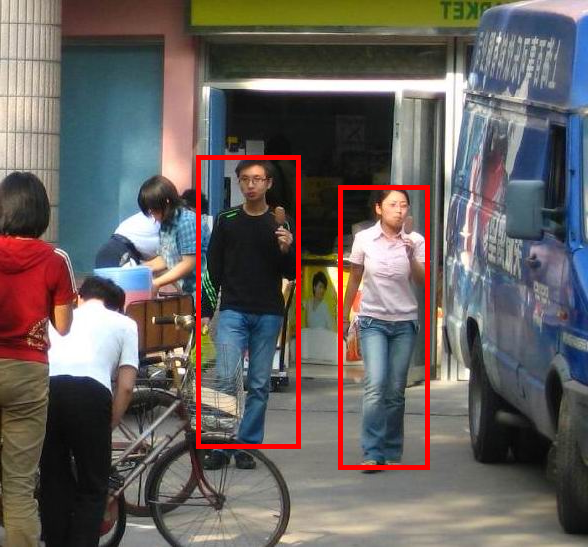

In [ ]:
result = draw_bounding_boxes(flipped_tensor, flipped_boxes, colors=['red']*boxes.shape[0], width=5)
ToPILImage()(result)

## 12.6 Transforms (V2)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

In [ ]:
import torchvision
torchvision.disable_beta_transforms_warning()

# import torchvision.transforms as transforms  # old v1
import torchvision.transforms.v2 as transforms # new v2

from torchvision.transforms.v2 import ToPILImage

In [ ]:
flip_v2 = transforms.RandomHorizontalFlip(p=1.0)
flipped_tensor_v2 = flip_v2(image)

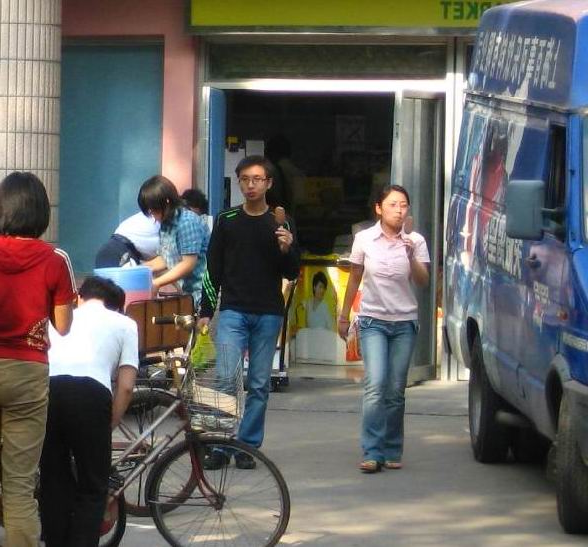

In [ ]:
ToPILImage()(flipped_tensor_v2)

In [ ]:
flip_v2(boxes)

tensor([[469., 249., 185., 158.],
        [448., 391., 155., 287.]])

In [ ]:
flipped_boxes

tensor([[338., 185., 429., 469.],
        [196., 155., 300., 448.]])

In [ ]:
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat

pascal_voc = BoundingBoxFormat.XYXY
image_hw = (image.shape[1], image.shape[2])

wrapped_boxes = BoundingBoxes(boxes, format=pascal_voc, canvas_size=image_hw)
wrapped_boxes

BoundingBox([[158., 185., 249., 469.],
             [287., 155., 391., 448.]], format=BoundingBoxFormat.XYXY, spatial_size=(547, 588))

In [ ]:
flipped_boxes_v2 = flip_v2(wrapped_boxes)
flipped_boxes_v2

BoundingBox([[339., 185., 430., 469.],
             [197., 155., 301., 448.]], format=BoundingBoxFormat.XYXY, spatial_size=(547, 588))

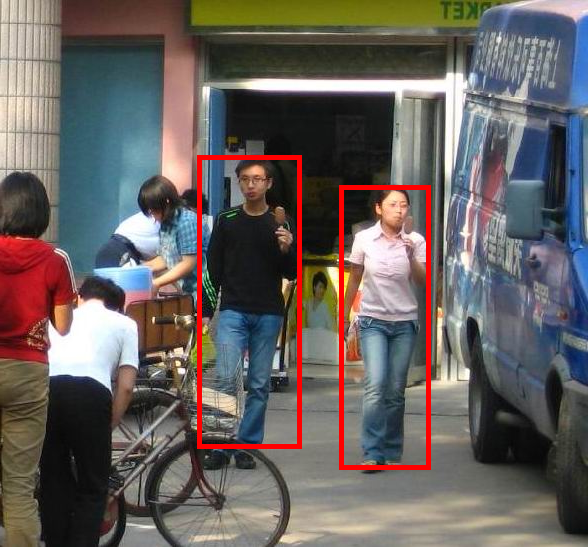

In [ ]:
result = draw_bounding_boxes(flipped_tensor_v2, flipped_boxes_v2, colors=['red']*boxes.shape[0], width=5)
ToPILImage()(result)

### 12.6.1 TV_Tensors

In [ ]:
image_tensor = read_image('PennFudanPed/PNGImages/FudanPed00042.png')
image_hw = image_tensor.shape[-2:]

mask_filename = 'PennFudanPed/PedMasks/FudanPed00042_mask.png'
merged_mask = read_image(mask_filename)
instances = merged_mask.unique()[1:]

masks = (merged_mask == instances.view(-1, 1, 1))
boxes = masks_to_boxes(masks)

#### 12.6.1.1 Image

In [ ]:
from torchvision.tv_tensors import Image

wrapped_image = Image(image_tensor)
wrapped_image

Image([[[216, 214, 211,  ..., 240, 196, 167],
        [221, 220, 218,  ..., 239, 195, 166],
        [226, 225, 224,  ..., 237, 193, 165],
        ...,
        [116, 117, 118,  ..., 102,  97,  92],
        [122, 123, 125,  ...,  96,  83,  74],
        [127, 128, 130,  ...,  86,  68,  57]],

       [[204, 202, 199,  ..., 229, 185, 156],
        [206, 205, 203,  ..., 228, 184, 155],
        [209, 208, 207,  ..., 226, 182, 154],
        ...,
        [116, 117, 119,  ...,  93,  89,  84],
        [122, 123, 126,  ...,  84,  73,  64],
        [127, 128, 131,  ...,  74,  58,  47]],

       [[208, 206, 203,  ..., 211, 167, 138],
        [213, 212, 210,  ..., 210, 166, 137],
        [219, 218, 217,  ..., 208, 164, 136],
        ...,
        [104, 105, 105,  ...,  78,  76,  73],
        [110, 111, 112,  ...,  68,  61,  52],
        [115, 116, 117,  ...,  58,  46,  35]]], dtype=torch.uint8, )

#### 12.6.1.2 BoundingBoxes and BoundingBoxFormat

In [ ]:
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat

image_hw = wrapped_image.shape[-2:]
pascal_voc = BoundingBoxFormat.XYXY

wrapped_boxes = BoundingBoxes(boxes, format=pascal_voc, canvas_size=image_hw)
wrapped_boxes

BoundingBox([[158., 185., 249., 469.],
             [287., 155., 391., 448.]], format=BoundingBoxFormat.XYXY, spatial_size=torch.Size([547, 588]))

In [ ]:
from torchvision.ops import box_area, box_convert

areas = box_area(wrapped_boxes)
areas

tensor([25844., 30472.])

In [ ]:
box_convert(wrapped_boxes, 'xyxy', 'xywh')

tensor([[158., 185.,  91., 284.],
        [287., 155., 104., 293.]])

#### 12.6.1.3 Mask

In [ ]:
from torchvision.tv_tensors import Mask

wrapped_masks = Mask(masks)
wrapped_masks

Mask([[[False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       ...,
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False]],

      [[False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       ...,
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False]]])

#### 12.6.1.4 Video

In [ ]:
from torchvision.tv_tensors import Video

### 12.6.2 Transforms

In [ ]:
augment_v2 = transforms.Compose([
    transforms.RandomRotation(30),
])

aug_image_v2, aug_boxes_v2, aug_masks_v2 = augment_v2(wrapped_image, wrapped_boxes, wrapped_masks)

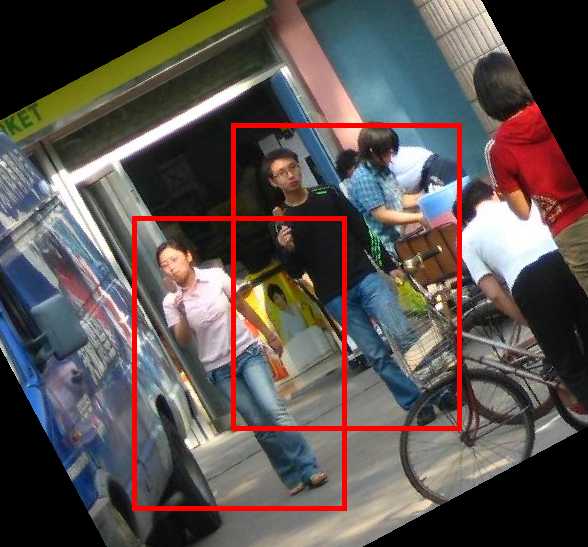

In [ ]:
result = draw_bounding_boxes(aug_image_v2, aug_boxes_v2, colors=['red']*aug_boxes_v2.shape[0], width=5)
ToPILImage()(result)

In [ ]:
labels = torch.ones((len(instances),), dtype=torch.int64)
targets = {'boxes': wrapped_boxes, 'masks': wrapped_masks, 'labels': labels}

aug_image_v2, aug_targets_v2 = augment_v2(wrapped_image, targets)
aug_targets_v2

{'boxes': BoundingBox([[157.8318, 185.0858, 249.3721, 469.2585],
              [286.7745, 154.8156, 391.3319, 448.0130]], format=BoundingBoxFormat.XYXY, spatial_size=torch.Size([547, 588])),
 'masks': Mask([[[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]],
 
       [[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]]),
 'labels': tensor([1, 1])}

#### 12.6.2.1 SanitizeBoundingBox

In [ ]:
sanitized_v2 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.SanitizeBoundingBoxes(),
])
sanitized_image_v2, sanitized_targets_v2 = sanitized_v2(wrapped_image, targets)
sanitized_targets_v2

{'boxes': BoundingBox([[117.7278, 156.8299, 269.9290, 453.9872],
              [248.1572, 156.4353, 415.0417, 465.2716]], format=BoundingBoxFormat.XYXY, spatial_size=torch.Size([547, 588])),
 'masks': Mask([[[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]],
 
       [[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]]),
 'labels': tensor([1, 1])}

#### 12.6.2.2 `ToImage()` and `ToDType()`

In [ ]:
pil_image = PIL.Image.open('PennFudanPed/PNGImages/FudanPed00042.png')

deprecated_t = transforms.ToTensor()
suggested_t = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])

torch.allclose(deprecated_t(pil_image), suggested_t(pil_image))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


True

### 12.6.3 Albumentations

In [ ]:
image_tensor = read_image('PennFudanPed/PNGImages/FudanPed00042.png')
image_hw = image_tensor.shape[-2:]

mask_filename = 'PennFudanPed/PedMasks/FudanPed00042_mask.png'
merged_mask = read_image(mask_filename)
instances = merged_mask.unique()[1:]

masks = (merged_mask == instances.view(-1, 1, 1))
boxes = masks_to_boxes(masks)

In [ ]:
numpy_image = image_tensor.permute(1, 2, 0).numpy() # from PyTorch's CHW to PIL's HWC format

In [ ]:
import albumentations as A
import random
from albumentations.pytorch.transforms import ToTensorV2

transform = A.Compose([
    A.RandomCrop(width=299, height=299),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

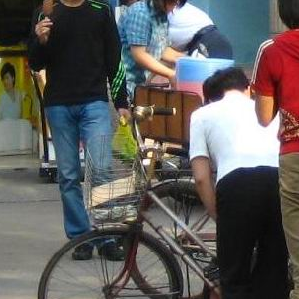

In [ ]:
random.seed(34)
transformed = transform(image=numpy_image)
transformed_image = transformed["image"]
ToPILImage()(transformed_image)

In [ ]:
transform = A.Compose([
    A.RandomCrop(width=299, height=299),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [ ]:
random.seed(34)
transformed = transform(image=numpy_image, bboxes=boxes, class_labels=[1, 1])
transformed['bboxes'], transformed['class_labels']

([(27.00000110268593, 0.0, 131.00000303983688, 239.0000074505806)], [1])

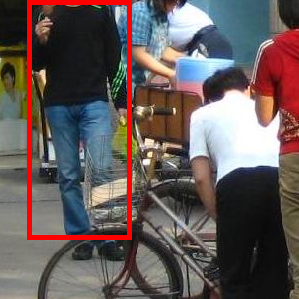

In [ ]:
result = draw_bounding_boxes(transformed['image'],
                             torch.as_tensor(transformed['bboxes']),
                             colors=['red']*len(transformed['bboxes']), width=5)
ToPILImage()(result)

### 12.6.4 Wrapping Datasets

In [ ]:
from torchvision.datasets import OxfordIIITPet

In [ ]:
pets = OxfordIIITPet(root='./pets', split='trainval', target_types=['category', 'segmentation'], download=True)

100%|██████████| 791918971/791918971 [00:24<00:00, 32124920.62it/s]


Extracting pets/oxford-iiit-pet/images.tar.gz to pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16219547.70it/s]


Extracting pets/oxford-iiit-pet/annotations.tar.gz to pets/oxford-iiit-pet


In [ ]:
image, target = pets[1]
image, target

(<PIL.Image.Image image mode=RGB size=450x313>,
 (0, <PIL.PngImagePlugin.PngImageFile image mode=L size=450x313>))

In [ ]:
wrapped_pets = torchvision.datasets.wrap_dataset_for_transforms_v2(pets)

In [ ]:
new_image, wrapped_targets = wrapped_pets[1]
new_image, wrapped_targets

(<PIL.Image.Image image mode=RGB size=450x313>,
 (0,
  Mask([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)))

In [ ]:
with open('./pets/oxford-iiit-pet/annotations/xmls/Abyssinian_100.xml') as  f:
    print(f.read())

<annotation><folder>OXIIIT</folder><filename>Abyssinian_100.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>394</width><height>500</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>151</xmin><ymin>71</ymin><xmax>335</xmax><ymax>267</ymax></bndbox><difficult>0</difficult></object></annotation>



## 12.7 Custom Dataset for Object Detection

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In the constructor, `__init__()`, method you have to set up your dataset so it should take arguments such as
- `image_folder`: the folder where your images are stored
- `mask_folder`: the folder where the corresponding masks, if any, are stored
- `annotations`: the path to a CSV file or a Pandas Dataframe containing the annotated boxes (we're assuming the XYXY format in our example)
- `transforms`: the prescribed and/or augmentation transforms to be applied to your images

Make sure your images and masks are aligned, that is, their names match each other. This is extremely important because we'll be retrieving them both using the same index, so the files must be ordered in the same way in both folders.

The `__getitem()__` is where the action happens: it should load an image (returned as an instance of `datapoints.Image`) and build a target dictionary containing all required keys:
  - `boxes` (`FloatTensor[N, 4]`): where N is the number of annotated boxes in the image, each having four coordinates in the XYXY format (`[xmin, ymin, xmax, ymax]`)
  - `area` (`Tensor[N]`): it contains the areas of the N boxes
  - `masks` (`UInt8Tensor[N, H, W]`): (optional) it contains "pixel values" indicating the instance they refer to - these masks are obtained by splitting the merged masks loaded from disk
  - `labels` (`Int64Tensor[N]`): it contains the class indices corresponding to each box (and mask) - it should be `tensor([0])` if there are no annotated boxes, as it stands for the background class
  - `image_id` (`Int64Tensor[1]`): it contains the unique identifier for the image, like its corresponding index in the dataset - we're adding one to the index value because during evaluation, it will serve us well to avoid a 0-based id number
  - `iscrowd` (`UInt8Tensor[N]`): it may be either 0 (false) or 1 (true), and images where it is set to true will be ignored for the purposes of evaluation - it is safe to set it to zero
  - `keypoints` (`FloatTensor[N, K, 3]`): (optional) it contains K keypoints in the `[x, y, visibility]` for each annotated box, where `visibility` indicates if a particular keypoint is visible or not

Make sure every entry in the dictionary is a tensor to avoid issues later whenever you have negative images (that is, without any annotated boxes in them).

Finally, the `__len__()` method simply indicates the number of samples in our dataset, as usual.

In [ ]:
import os
import pandas as pd
import torch
from torchvision.io import read_image, ImageReadMode
from torchvision.tv_tensors import Image, BoundingBoxes, BoundingBoxFormat, Mask
from torchvision.ops import masks_to_boxes, box_area
from torchvision.datasets import VisionDataset

class ObjDetectionDataset(VisionDataset):
    def __init__(self, image_folder, annotations=None, mask_folder=None, transforms=None):
        super().__init__(image_folder, transforms, None, None)
        # folder where images are stored
        self.image_folder = image_folder
        # path to a CSV file or pandas dataframe with annotations
        self.annotations = annotations
        # folder where masks, if any, are stored
        self.mask_folder = mask_folder
        # transforms/augmentations to be applied to images
        self.transforms = transforms

        # gets the list of all images sorted by name
        self.images = list(sorted(os.listdir(image_folder)))

        self.df_boxes = None
        assert (annotations is not None) or (mask_folder is not None), "At least one, annotations or masks, must be supplied"

        # if a CSV or dataframe was prodivded
        if annotations is not None:
            if isinstance(annotations, str):
                self.df_boxes = pd.read_csv(annotations)
            else:
                self.df_boxes = annotations
            # makes sure the annotations are in the XYXY format
            assert len(set(self.df_boxes.columns).intersection({'filename', 'xmin', 'ymin', 'xmax', 'ymax'})) == 5, "Missing columns in CSV"
            # only annotated images are considered - it overwrites the images attribute
            self.images = self.df_boxes['filename'].unique().tolist()

        self.masks = None
        # if there are masks, makes sure each image has its own mask
        if mask_folder is not None:
            self.masks = list(sorted(os.listdir(mask_folder)))
            assert len(self.masks) == len(self.images), "Every image must have one, and only one, mask"

    def __getitem__(self, idx):
        image_filename = os.path.join(self.image_folder, self.images[idx])
        image_tensor = read_image(image_filename, mode=ImageReadMode.RGB)
        # gets the last two dimensions, height and width
        image_hw = image_tensor.shape[-2:]

        labels = None
        # If there are masks, we work with them
        if self.masks is not None:
            mask_filename = os.path.join(self.mask_folder, self.masks[idx])
            merged_mask = read_image(mask_filename)
            # checks how many instances are present in the mask
            # assumes the first one, zero, is background only
            instances = merged_mask.unique()[1:]

            # splits the merged mask, so there's one mask for instance
            masks = (merged_mask == instances.view(-1, 1, 1))
            # converts masks into boxes
            boxes = masks_to_boxes(masks)
            # uses the datapoints namespace to wrap the masks
            wrapped_masks = Mask(masks)
        # No masks, so we fallback to a DF of annotated boxes
        else:
            # retrieves the annotations for the corresponding image
            annots = self.df_boxes.query(f'filename == "{self.images[idx]}"')
            # keeps only the coordinates
            boxes = torch.as_tensor(annots.dropna()[['xmin', 'ymin', 'xmax', 'ymax']].values)
            # if there are labels available as well, retrieves them
            if 'label' in annots.columns:
                labels = torch.as_tensor(annots.dropna()['label'].values)
            wrapped_masks = None

        # uses the datapoints namespace to wrap the boxes
        wrapped_boxes = BoundingBoxes(boxes, format=BoundingBoxFormat.XYXY, canvas_size=image_hw)
        num_objs = len(boxes)

        if len(boxes):
            if labels is None:
                # if there are no labels, we assume every instance is of
                # the same, and only, class
                labels = torch.ones((num_objs,), dtype=torch.int64)
            area = box_area(wrapped_boxes)
        else:
            # Only background, no boxes
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.tensor([0.], dtype=torch.float32)

        # creates a target dictionary with all elements
        target = {
            'boxes': wrapped_boxes,
            'area': area,
            'labels': labels,
            'image_id': torch.tensor([idx+1]),
            'iscrowd': torch.zeros((num_objs,), dtype=torch.int64)
        }
        # if there are masks, includes them
        if wrapped_masks is not None:
            target['masks'] = wrapped_masks

        # uses the datapoints namespace to wrap the image
        image = Image(image_tensor)

        # if there are transformations/augmentations
        # apply them to the image and target
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.images)

In [ ]:
penn_ds = ObjDetectionDataset(image_folder='PennFudanPed/PNGImages', mask_folder='PennFudanPed/PedMasks')
len(penn_ds)

170

In [ ]:
image, targets = penn_ds[41]

In [ ]:
targets

{'boxes': BoundingBox([[158., 185., 249., 469.],
              [287., 155., 391., 448.]], format=BoundingBoxFormat.XYXY, spatial_size=torch.Size([547, 588])),
 'area': tensor([25844., 30472.]),
 'labels': tensor([1, 1]),
 'image_id': tensor([42]),
 'iscrowd': tensor([0, 0]),
 'masks': Mask([[[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]],
 
       [[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False

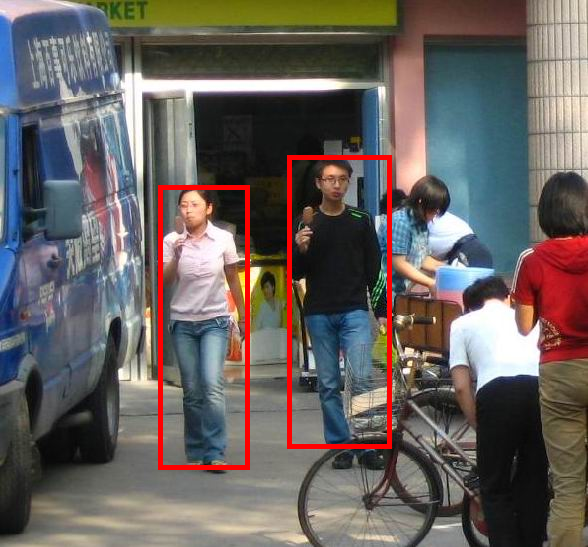

In [ ]:
result = draw_bounding_boxes(image, targets['boxes'], colors=['red']*targets['boxes'].shape[0], width=5)
ToPILImage()(result)